# React Agent with Tools

In [2]:
#Importing the required library for the setting up of the model 
from dotenv import load_dotenv
load_dotenv(override=True)
import os 
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
#Selecting the model from Groq
model = "deepseek-r1-distill-llama-70b"

In [92]:
#Building llm model using groq / deepseek 
from langchain_groq import ChatGroq
llm = ChatGroq(model_name=model)
llm.invoke("Tell me the name of the model: ").content

"<think>\nOkay, the user is asking for the name of the model. I should let them know it's DeepSeek-R1-Lite-Preview.\n</think>\n\nThe model you are interacting with is named DeepSeek-R1-Lite-Preview."

In [7]:
#Display the result more readable 
import pprint
pprint.pprint(llm.invoke("Tell me the name of the model: ").content)

('<think>\n'
 "Okay, the user is asking me to tell them the name of the model. Since I'm an "
 'AI, I should respond in a friendly and helpful manner. I need to let them '
 "know that I can't provide internal information about myself, but I'm here to "
 'assist with any other questions or tasks they might have. I should keep it '
 'conversational and make sure they feel supported.\n'
 '</think>\n'
 '\n'
 "I'm here to help with any questions or tasks you have! Let me know how I can "
 'assist you today.')


# Defining Workflow for ReACT Agent

In [8]:
#Importing all the required libraries 
import operator
from typing import List
from langgraph.graph.message import add_messages
from pydantic import BaseModel , Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

MessagesState General

In [11]:
#Importing the libraray 
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AIMessage, HumanMessage

#Defining initial response 
def initial_response(state: MessagesState):
    return {"messages" : [AIMessage(content="Thank You for your interest")]}

#DEfine followup message 
def follow_up(state: MessagesState):
    return{"messages": [AIMessage(content="This is the followup message")]}

#Building the workflow 
graph = StateGraph(MessagesState)

graph.add_node("initial_response", initial_response)
graph.add_node("follow_up", follow_up)

graph.set_entry_point("initial_response")

app = graph.compile()

#Executing the app 
app.invoke({"messages" : [HumanMessage(content="Hello")]}) 



{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='606aa537-15f7-42a6-a7b9-bb272041077d'),
  AIMessage(content='Thank You for your interest', additional_kwargs={}, response_metadata={}, id='6c1a95a2-119d-4df0-9fe2-abc963a2291c')]}

In [ ]:
MessagesState

Creating a Function 

In [ ]:
def call_model(state: MessagesState):
    # The 'messages' in MessagesState will be a list of BaseMessage objects.
    # If the input was a string, LangGraph's default reducer for MessagesState
    # will try to append it, but we need to ensure it's a HumanMessage
    # before the LLM can process it.

    # Retrieve the last message from the state
    last_message = state['messages'][-1]

    human_message_obj = last_message
    
    # Convert the last message to a HumanMessage if it's a string
#    if isinstance(last_message, str):
#        print("Input is String!!!!")
#        human_message_obj = HumanMessage(content=last_message)
#    elif isinstance(last_message, BaseMessage):
#        print("Input is Human Message!!!!")
#        human_message_obj = last_message
#    else:
#        # Handle unexpected types if necessary, or raise an error
#        raise ValueError(f"Unexpected message type in state: {type(last_message)}")

    print("This is my current message:", human_message_obj)

    # Pass a list containing the HumanMessage object to the LLM
    response = llm.invoke([human_message_obj])

    # The MessagesState's default reducer will append this AIMessage to the history
    return {"messages": [response]}

In [114]:
state = {
    "messages": ["Hi there!"]   # <-- a raw string, not a HumanMessage
}
result = call_model(state)

Input is String!!!!
This is my current message: content='Hi there!' additional_kwargs={} response_metadata={}


Creating a workflow

In [115]:
#Here we design a simple workflow 
workflow = StateGraph(MessagesState)

#Adding nodes 
workflow.add_node("bot", call_model)

#Adding Edges onto the workflow 
workflow.add_edge(START, "bot")
workflow.add_edge("bot", END)

#Compiling the workflow
app=workflow.compile()

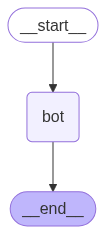

In [116]:
#Displaying the workflow
from IPython.display import Image, display 
display(Image(app.get_graph().draw_mermaid_png()))

In [117]:
# Define the input
input_data = {"messages": ["hi hello how are you?"]}

# Invoke the app
app.invoke(input_data)

Input is Human Message!!!!
This is my current message: content='hi hello how are you?' additional_kwargs={} response_metadata={} id='2087d102-d1ce-496b-9b65-16adffffee9d'


{'messages': [HumanMessage(content='hi hello how are you?', additional_kwargs={}, response_metadata={}, id='2087d102-d1ce-496b-9b65-16adffffee9d'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 9, 'total_tokens': 53, 'completion_time': 0.191474274, 'prompt_time': 0.000204998, 'queue_time': 0.054105372, 'total_time': 0.191679272}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--017588fc-a652-41d9-8b19-99f3b2e0d89b-0', usage_metadata={'input_tokens': 9, 'output_tokens': 44, 'total_tokens': 53})]}

In [118]:
input_data = {"messages": [HumanMessage(content="hi hello how are you?")]}
# Invoke the app
app.invoke(input_data)

Input is Human Message!!!!
This is my current message: content='hi hello how are you?' additional_kwargs={} response_metadata={} id='ee3ab383-8ea5-4c80-bc8c-e749828cea04'


{'messages': [HumanMessage(content='hi hello how are you?', additional_kwargs={}, response_metadata={}, id='ee3ab383-8ea5-4c80-bc8c-e749828cea04'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.184120666, 'prompt_time': 0.000439195, 'queue_time': 0.053150855, 'total_time': 0.184559861}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--dcc2367f-4a06-4968-b8ca-45c9fe0a3c0e-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

In [ ]:
from typing import List, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END, START, MessagesState # Import MessagesState
from langchain_openai import ChatOpenAI


def call_model(state: MessagesState):
    # The 'messages' in MessagesState will be a list of BaseMessage objects.
    # If the input was a string, LangGraph's default reducer for MessagesState
    # will try to append it, but we need to ensure it's a HumanMessage
    # before the LLM can process it.

    # Retrieve the last message from the state
    last_message = state['messages'][-1]

    # Convert the last message to a HumanMessage if it's a string
    if isinstance(last_message, str):
        human_message_obj = HumanMessage(content=last_message)
    elif isinstance(last_message, BaseMessage):
        human_message_obj = last_message
    else:
        # Handle unexpected types if necessary, or raise an error
        raise ValueError(f"Unexpected message type in state: {type(last_message)}")

    print("This is my current message:", human_message_obj)

    # Pass a list containing the HumanMessage object to the LLM
    response = llm.invoke([human_message_obj])

    # The MessagesState's default reducer will append this AIMessage to the history
    return {"messages": [response]}

# Here we design a simple workflow
workflow = StateGraph(MessagesState) # Use the pre-built MessagesState

# Adding nodes
workflow.add_node("bot", call_model)

# Adding Edges onto the workflow
workflow.add_edge(START, "bot")
workflow.add_edge("bot", END)

# Compiling the workflow
app = workflow.compile()



In [101]:
# Define the input as a normal list of strings
input_data = {"messages": ["hi hello how are you?"]}

# Invoke the app
result = app.invoke(input_data)

print("\n--- Result ---")
print(result)

# You can now invoke it with another message and see the history grow
print("\n--- Second Invocation ---")
second_input_data = {"messages": ["Tell me a joke."]}
second_result = app.invoke(second_input_data, config={"configurable": {"thread_id": "my_thread_1"}})
# Note: For maintaining history across invocations, you typically need to use a checkpointing system (like MemorySaver or a database)
# and use a 'thread_id' in the config. Without it, each 'invoke' is a fresh start unless you pass the full history.
# For simplicity, this example just shows the first message being a string.
print(second_result)

This is my current message: content='hi hello how are you?' additional_kwargs={} response_metadata={} id='9eaaa1b7-c046-41a4-9f26-511b6aff23da'

--- Result ---
{'messages': [HumanMessage(content='hi hello how are you?', additional_kwargs={}, response_metadata={}, id='9eaaa1b7-c046-41a4-9f26-511b6aff23da'), AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.209735931, 'prompt_time': 0.000213248, 'queue_time': 0.054098872, 'total_time': 0.209949179}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--eb24b16a-b048-4a40-b2ec-f0cbd0ad3e96-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

--- Seco

In [119]:
#Generate output in a streaming manner
for output in app.stream(input): 
    for key, value in output.items():
        print("Output from {key}")
        print("==================")
        print(value)
        print("\n")

Input is Human Message!!!!
This is my current message: content='hi hello how are you?' additional_kwargs={} response_metadata={} id='3dcf6295-dad5-4d2a-aa54-96b18c5cf581'
Output from {key}
{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.183627166, 'prompt_time': 0.000215177, 'queue_time': 0.055359433000000006, 'total_time': 0.183842343}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--21a851bb-ddc3-4f6d-8107-561b84eba51b-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}




Tool Calling

In [120]:
#Enabling the workflow for tool calling 
@tool

def search(query: str):
    """ This is my custom tool to search weather"""
    
    if "delhi" in query.lower():
        return "Temperature in 45 Degree and Sunny"
    
    return "Temperature is 25 degree and cloudy"

In [121]:
#Testing the tool 
search.invoke("What is the temprature in Kashmir?")

'Temperature is 25 degree and cloudy'

In [122]:
#Testing the tool 
search.invoke("What is the temprature in Delhi?")

'Temperature in 45 Degree and Sunny'

In [123]:
search

StructuredTool(name='search', description='This is my custom tool to search weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000022D4F733A60>)

Binding the tool onto LLM

In [125]:
#Creating a variable to hold the tool name 
tools = [search]

Next we pass the tool onto LLM

In [128]:
#Binding tools onto LLM + It takes a list of tools
llm_with_tools = llm.bind_tools(tools)

In [130]:
#Asking question to this model 
response=llm_with_tools.invoke("What is the weather in delhi?")
response.content

''

There is no response.

In [131]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'g2q19aa2a',
  'type': 'tool_call'}]

Here we can see that tool is called.

In [135]:
#Modifing the call_model function to use the LLM_tool_Call functionality 
def call_model(state: MessagesState):
    question = state["messages"] #Getting question from the message 
    response = llm_with_tools.invoke(question) #Question is passed as an agumrnet for LLM 
    return { "messages" : [response]}

In [136]:
# Define the input as a normal list of strings
input_data = {"messages": ["hi hello how are you?"]}

# Invoke the function 
call_model(input_data)

{'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'reasoning_content': 'Alright, let\'s see what the user is asking for here. They provided a message: "hi hello how are you?" which seems like a greeting. I need to figure out the best way to respond.\n\nFirst, I should consider the context. The user might be testing the system or just starting a conversation. Since the message is a greeting, a friendly and welcoming response would be appropriate.\n\nI should make sure the response is polite and acknowledges their greeting. Maybe something like, "Hello! How can I assist you today?" This keeps the conversation open and invites them to specify what they need help with.\n\nI also need to ensure that the response is clear and concise, without any unnecessary information. Keeping it simple will help the user understand that I\'m here to help with their queries.\n'}, response_metadata={'token_usage': {'completion_tokens': 172, 'prompt_tokens': 130, 'total

In [138]:
# Define the input as a normal list of strings
input_data = {"messages": ["What is the weather in delhi?"]}

# Invoke the function 
response=call_model(input_data)

#Check the messages from response 
response["messages"]

[AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, the user is asking about the weather in Delhi. They probably need this information to plan their day or maybe for travel. Since I have a tool called "search" that\'s designed for weather queries, I should use that. I\'ll format the function call with the tool name and the query as "weather in delhi". This should give the user the current weather details they\'re looking for.\n', 'tool_calls': [{'id': 'zdghsy1cm', 'function': {'arguments': '{"query":"weather in delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 132, 'total_tokens': 239, 'completion_time': 0.513525749, 'prompt_time': 0.008453004, 'queue_time': 0.054199776000000005, 'total_time': 0.521978753}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0f37d03f-756e-4f60-9a8d-13043948067f-

In [141]:
response["messages"]

[AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, the user is asking about the weather in Delhi. They probably need this information to plan their day or maybe for travel. Since I have a tool called "search" that\'s designed for weather queries, I should use that. I\'ll format the function call with the tool name and the query as "weather in delhi". This should give the user the current weather details they\'re looking for.\n', 'tool_calls': [{'id': 'zdghsy1cm', 'function': {'arguments': '{"query":"weather in delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 132, 'total_tokens': 239, 'completion_time': 0.513525749, 'prompt_time': 0.008453004, 'queue_time': 0.054199776000000005, 'total_time': 0.521978753}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0f37d03f-756e-4f60-9a8d-13043948067f-

In [143]:
response["messages"][-1].content

''

In [140]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in delhi'},
  'id': 'zdghsy1cm',
  'type': 'tool_call'}]

In [145]:
# Define the input as a normal list of strings
input_data = {"messages": ["Where is Kerala?"]}

# Invoke the function 
response=call_model(input_data)

#Check the messages from response 
response["messages"][-1].tool_calls


[]

In [160]:
#Create a router function 
#Here we define a logic to end the process or to call the tool. 

def router_function(state: MessagesState):
    message = state["messages"] #Take the  message rececied from MessageSate 
    last_message = message[-1] #Taking the last message 
    if last_message.tool_calls: 
        return "tools"
    return END 

In [147]:
tools

[StructuredTool(name='search', description='This is my custom tool to search weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000022D4F733A60>)]

In [148]:
#Fitting the tool within langgraph workflow 
tool_node = ToolNode(tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='This is my custom tool to search weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000022D4F733A60>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [179]:
#Creating a new workflow based on LLM with tools 
workflow2 = StateGraph(MessagesState)

#ADding nodes 
workflow2.add_node("llmwithtool", call_model)
workflow2.add_node("mytools", tool_node)

#Adding Edges 
workflow2.add_edge(START, "llmwithtool")

workflow2.add_conditional_edges(
    "llmwithtool", 
    router_function,
    {   "tools" :"mytools",
        END     : END
     })

#Adding Edges 
workflow2.add_edge("mytools", END)



In [180]:
#Compile the workflow 
app2 = workflow2.compile()

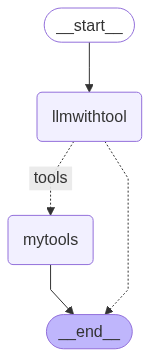

In [181]:
#Visualising the workflow
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

Checking the working of the app2

In [154]:
#Invoking the workflow 
response = app2.invoke({"messages": ["What is the weather in Kerala?"]})


In [185]:
app2.invoke({"messages": ["What is the weather in Kerala?"]})

{'messages': [HumanMessage(content='What is the weather in Kerala?', additional_kwargs={}, response_metadata={}, id='421caf58-5006-4bf7-b17f-0c76728bf00d'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the weather in Kerala. I need to figure out the best way to help them. I have a tool called "search" that I can use for this purpose. It requires a query parameter, so I should structure the function call with "Kerala weather" as the query. That should provide the necessary information the user is looking for.\n', 'tool_calls': [{'id': 'f7j8thdas', 'function': {'arguments': '{"query":"Kerala weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 132, 'total_tokens': 232, 'completion_time': 0.468973333, 'prompt_time': 0.008455074, 'queue_time': 0.054319496, 'total_time': 0.477428407}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307a

In [155]:
response["messages"][-1].content


'Temperature is 25 degree and cloudy'

In [158]:
#Invoking the workflow 
response = app2.invoke({"messages": ["Tell me about cricket?"]})

In [159]:
response["messages"][-1].content


'Temperature is 25 degree and cloudy'

In [182]:
#Invoking the workflow 
response = app2.invoke({"messages": ["Hello, How are you?"]})

In [184]:
response

{'messages': [HumanMessage(content='Hello, How are you?', additional_kwargs={}, response_metadata={}, id='9a3ee89e-2480-4e4b-9661-69979360a2cb'),
  AIMessage(content="Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you. How can I assist you today? If you need anything, feel free to ask!", additional_kwargs={'reasoning_content': 'Alright, the user greeted me with "Hello, How are you?" which is a friendly opener. I need to respond politely and offer assistance. Since I have a tool for searching weather, I should mention that I can help with the weather if they need it. I\'ll keep it simple and open-ended to encourage them to ask for what they need.\n'}, response_metadata={'token_usage': {'completion_tokens': 119, 'prompt_tokens': 131, 'total_tokens': 250, 'completion_time': 0.573809002, 'prompt_time': 0.009409546, 'queue_time': 0.263239308, 'total_time': 0.583218548}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76

In [183]:
response["messages"][-1].content


"Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you. How can I assist you today? If you need anything, feel free to ask!"

In [187]:
response

{'messages': [HumanMessage(content='Hello, How are you?', additional_kwargs={}, response_metadata={}, id='9a3ee89e-2480-4e4b-9661-69979360a2cb'),
  AIMessage(content="Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you. How can I assist you today? If you need anything, feel free to ask!", additional_kwargs={'reasoning_content': 'Alright, the user greeted me with "Hello, How are you?" which is a friendly opener. I need to respond politely and offer assistance. Since I have a tool for searching weather, I should mention that I can help with the weather if they need it. I\'ll keep it simple and open-ended to encourage them to ask for what they need.\n'}, response_metadata={'token_usage': {'completion_tokens': 119, 'prompt_tokens': 131, 'total_tokens': 250, 'completion_time': 0.573809002, 'prompt_time': 0.009409546, 'queue_time': 0.263239308, 'total_time': 0.583218548}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76

# Building React Agent 

In [188]:
#Importing all the required libraries 
import operator
from typing import List
from langgraph.graph.message import add_messages
from pydantic import BaseModel , Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [189]:
#Importing the required library for the setting up of the model 
from dotenv import load_dotenv
load_dotenv(override=True)
import os 
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

#Selecting the model from Groq
model = "deepseek-r1-distill-llama-70b"

In [190]:
#Enabling the workflow for tool calling 
@tool

def search(query: str):
    """ This is my custom tool to search weather"""
    
    if "delhi" in query.lower():
        return "Temperature in 45 Degree and Sunny"
    
    return "Temperature is 25 degree and cloudy"

#Converting the tool onto ToolNode 
#Fitting the tool within langgraph workflow 
tool_node = ToolNode(tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000022D510DC900>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [191]:
#Creating a variable to hold the tool name 
tools = [search]

#Binding tools onto LLM + It takes a list of tools
llm_with_tools = llm.bind_tools(tools)

In [192]:

def router_function(state: MessagesState):
    message = state["messages"] #Take the  message rececied from MessageSate 
    last_message = message[-1] #Taking the last message 
    if last_message.tool_calls: 
        return "tools"
    return END 

In [193]:
#Creating a new workflow based on LLM with tools 
workflow2 = StateGraph(MessagesState)

#ADding nodes 
workflow2.add_node("llmwithtool", call_model)
workflow2.add_node("mytools", tool_node)

#Adding Edges 
workflow2.add_edge(START, "llmwithtool")
workflow2.add_conditional_edges(
    "llmwithtool", 
    router_function,
    {"tools":"mytools",
     END: END})
#Adding Edges 
workflow2.add_edge("mytools", END)

#Adding the Recurrance loop 


In [194]:
#Adding recurrance loop for REACT Framework 
workflow2.add_edge("mytools", "llmwithtool")

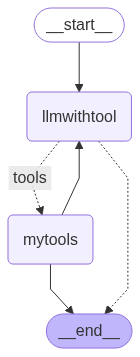

In [195]:
#Building the app via compiling()
app3=workflow2.compile()

#Display the result 
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))


Invoking the workflow using stream

In [197]:
for output in app3.stream({"messages":["What is the weather in Delhi?"]}):
    for key,value in output.items():
        print(f"Here is the output from {key}")
        print("============================")
        print(value)
        print("\n")

Here is the output from llmwithtool
{'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, the user is asking about the weather in Delhi. I need to help them by using the available tool. The tool provided is a function called "search" which takes a query as an argument.\n\nFirst, I should identify the function to call. Since the tool is named "search" and it\'s used for weather, that\'s the right choice.\n\nNext, I need to construct the arguments. The function requires a "query" parameter. The user\'s question is about Delhi\'s weather, so the query should be "weather in Delhi".\n\nPutting it all together, I\'ll format the tool call with the function name as "search" and the arguments as a JSON object containing the query.\n\nI should make sure the syntax is correct, using proper JSON formatting within the tool_call tags. That way, the system can process the request accurately and fetch the weather information for Delhi.\n', 'tool_calls': [{'id': 'm8rx8y0

In [198]:
for output in app3.stream({"messages":["What is the weather in Delhi and which hotel should i book in north Delhi?"]}):
    for key,value in output.items():
        print(f"Here is the output from {key}")
        print("============================")
        print(value)
        print("\n")

Here is the output from llmwithtool
{'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, the user is asking about the weather in Delhi and which hotel to book in North Delhi. First, I need to figure out how to get the weather information. I remember I have a tool called "search" that can help with that. So I\'ll use the search tool with the query "weather in Delhi" to get the current weather details.\n\nOnce I have the weather information, the next part is about booking a hotel in North Delhi. Since the user specifically mentioned North Delhi, I should look for hotels in that area. I don\'t have a direct tool for hotel bookings mentioned here, but maybe I can suggest using the same search tool to find hotels. Alternatively, I can recommend popular hotel booking platforms like Booking.com or MakeMyTrip where the user can search for options in North Delhi.\n\nI should structure the response to first provide the weather information using the search tool an

# LangGraph with Memory

In [199]:
#To configure memory for Langgraph 
from langgraph.checkpoint.memory import MemorySaver

In [200]:
#Create object of MemorySaver
memory = MemorySaver()

In [201]:
#Modifing the call_model function to use the LLM_tool_Call functionality 
def call_model(state: MessagesState):
    question = state["messages"] #Getting question from the message 
    response = llm_with_tools.invoke(question) #Question is passed as an agumrnet for LLM 
    return { "messages" : [response]}

In [202]:
#Enabling the workflow for tool calling 
@tool

def search(query: str):
    """ This is my custom tool to search weather"""
    
    if "delhi" in query.lower():
        return "Temperature in 45 Degree and Sunny"
    
    return "Temperature is 25 degree and cloudy"

#Converting the tool onto ToolNode 
#Fitting the tool within langgraph workflow 
tool_node = ToolNode(tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='This is my custom tool to search weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000022D50A9E340>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [203]:
#Creating a variable to hold the tool name 
tools = [search]

#Binding tools onto LLM + It takes a list of tools
llm_with_tools = llm.bind_tools(tools)

In [204]:

def router_function(state: MessagesState):
    message = state["messages"] #Take the  message rececied from MessageSate 
    last_message = message[-1] #Taking the last message 
    if last_message.tool_calls: 
        return "tools"
    return END 

In [206]:
#Recreating the workflow 
workflow3 = StateGraph(MessagesState) 


#adding hte nodes 
workflow3.add_node("llmwithtool", call_model)
workflow3.add_node("mytools", tool_node)

#Adding Edges 
workflow3.add_edge(START, "llmwithtool")
workflow3.add_conditional_edges(
    "llmwithtool", 
    router_function,
    {
        "tools" : "mytools",
        END : END 
    }
    
)
workflow3.add_edge("mytools", "llmwithtool")

In [207]:
#Compiling workflow + memory 
app4 = workflow3.compile(checkpointer=memory)

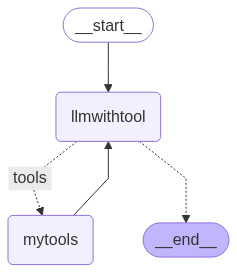

In [208]:
from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png()))

In [209]:
#Configuring Thread 
config = {"configurable": {"thread_id": "1"}}


In [226]:
#Configuring Thread 
config = {"configurable": {"thread_id": "1"}}

#Pass the configuration in stream 
events = app4.stream(
    {"messages": ["What is the weather in Delhi?"]}, config=config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in Delhi?
================================== Ai Message ==================================
Tool Calls:
  search (p9s2a7033)
 Call ID: p9s2a7033
  Args:
    query: weather in Delhi
================================= Tool Message =================================
Name: search

Temperature in 45 Degree and Sunny
================================== Ai Message ==================================

The current weather in Delhi is **45 degrees** and **sunny**.


In [ ]:
for event in events:
    event["messages"][-1].pretty_print()
    

In [228]:
#Asking another question on different city 
events=app4.stream(
    {"messages":["what is a weather in indore?"]},config=config,stream_mode="values"
    )

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in indore?
================================== Ai Message ==================================
Tool Calls:
  search (p9s2a7033)
 Call ID: p9s2a7033
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

Temperature is 25 degree and cloudy
================================== Ai Message ==================================

The current weather in Indore is **25 degrees** and **cloudy**.


In [229]:
memory.get(config)

{'v': 2,
 'ts': '2025-07-22T15:47:44.425224+00:00',
 'id': '1f067133-5453-6258-800d-44e5d93d8513',
 'channel_versions': {'__start__': '00000000000000000000000000000012.0.6373896316111395',
  'messages': '00000000000000000000000000000015.0.5391983724156162',
  'start:llmwithtool': '00000000000000000000000000000013.0.005697998514722524',
  'llmwithtool': '00000000000000000000000000000015.0.709050435035296',
  'branch:llmwithtool:router_function:mytools': '00000000000000000000000000000014.0.2654792964731961',
  'mytools': '00000000000000000000000000000015.0.6607421296627009'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000011.0.7152258968401143'},
  'llmwithtool': {'start:llmwithtool': '00000000000000000000000000000012.0.5441702963264097',
   'mytools': '00000000000000000000000000000014.0.5626713188543259'},
  'mytools': {'branch:llmwithtool:router_function:mytools': '00000000000000000000000000000013.0.01246700592429173'}},
 'pending_sends'

In [230]:
events=app4.stream(
    {"messages":["in which city the temp was 25 degree?"]},config=config,stream_mode="values"
    )


for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

in which city the temp was 25 degree?
================================== Ai Message ==================================

The temperature in **Indore** was **25 degrees**.


In [231]:
memory.get(config)


{'v': 2,
 'ts': '2025-07-22T15:54:13.842253+00:00',
 'id': '1f067141-d618-6509-8010-6cbb163ff369',
 'channel_versions': {'__start__': '00000000000000000000000000000017.0.09979815765688893',
  'messages': '00000000000000000000000000000018.0.1536621413491961',
  'start:llmwithtool': '00000000000000000000000000000018.0.8374482137213187',
  'llmwithtool': '00000000000000000000000000000018.0.3089948711663114',
  'branch:llmwithtool:router_function:mytools': '00000000000000000000000000000014.0.2654792964731961',
  'mytools': '00000000000000000000000000000015.0.6607421296627009'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000016.0.8397968798763659'},
  'llmwithtool': {'start:llmwithtool': '00000000000000000000000000000017.0.06938216948270748',
   'mytools': '00000000000000000000000000000014.0.5626713188543259'},
  'mytools': {'branch:llmwithtool:router_function:mytools': '00000000000000000000000000000013.0.01246700592429173'}},
 'pending_sends